## Stock Market Prediction And Forecasting Using Stacked LSTM

In this mini-project, I have tried to use LSTM for yet another interesting use case that is the prediction of the stock market movement. I have used Stacked LSTM which essentially has multiple hidden LSTM layers where each layer contains multiple memory cells.

One of the advantages of using Stacked LSTMs is that the addition of layers adds levels of abstraction of input observations over time, which is why they have been commonly used in challenging sequence prediction problems.

In [64]:
# Importing Libraries
import pandas_datareader as pdr # for data collection from API
import pandas as pd # for dataframe operations
import numpy as np # for mathematical computations
import matplotlib.pyplot as plt # For plotting
import math # for math operations
from numpy import array
from sklearn.preprocessing import MinMaxScaler # For minmax scaling 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_squared_error

In [3]:
# API key
key=''

In [16]:
# Collecting the End-of-Day prices for MICROSOFT (`MSFT`)
df = pdr.get_data_tiingo('MSFT', api_key=key)

df.to_csv('MSFT.csv') # Storing data in a csv file

df=pd.read_csv('MSFT.csv') # reading data in a pandas dataframe

df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,MSFT,2016-04-14 00:00:00+00:00,55.36,55.575,55.070,55.22,20877108,50.761318,50.958459,50.495408,50.632948,20877108,0.0,1.0
1,MSFT,2016-04-15 00:00:00+00:00,55.65,55.920,55.110,55.30,28793753,51.027228,51.274800,50.532086,50.706303,28793753,0.0,1.0
2,MSFT,2016-04-18 00:00:00+00:00,56.46,56.590,55.210,55.49,23785950,51.769943,51.889144,50.623779,50.880519,23785950,0.0,1.0
3,MSFT,2016-04-19 00:00:00+00:00,56.39,56.770,55.680,56.63,29596827,51.705758,52.054192,51.054736,51.925821,29596827,0.0,1.0
4,MSFT,2016-04-20 00:00:00+00:00,55.59,56.500,55.485,56.29,36195714,50.972213,51.806620,50.875935,51.614065,36195714,0.0,1.0


In [17]:
df.tail()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1252,MSFT,2021-04-06 00:00:00+00:00,247.86,249.400,246.88,247.61,22931923,247.86,249.400,246.88,247.61,22931923,0.0,1.0
1253,MSFT,2021-04-07 00:00:00+00:00,249.90,250.930,247.19,247.81,22719835,249.90,250.930,247.19,247.81,22719835,0.0,1.0
1254,MSFT,2021-04-08 00:00:00+00:00,253.25,254.139,252.00,252.77,23625197,253.25,254.139,252.00,252.77,23625197,0.0,1.0
1255,MSFT,2021-04-09 00:00:00+00:00,255.85,255.990,252.44,252.87,24326833,255.85,255.990,252.44,252.87,24326833,0.0,1.0
1256,MSFT,2021-04-12 00:00:00+00:00,255.91,257.670,254.62,254.71,27148668,255.91,257.670,254.62,254.71,27148668,0.0,1.0


Here, we will try to build a model on the closing price which is denoted by the `close` column in the data.

In [18]:
df1=df.reset_index()['close']

df1

0        55.36
1        55.65
2        56.46
3        56.39
4        55.59
         ...  
1252    247.86
1253    249.90
1254    253.25
1255    255.85
1256    255.91
Name: close, Length: 1257, dtype: float64

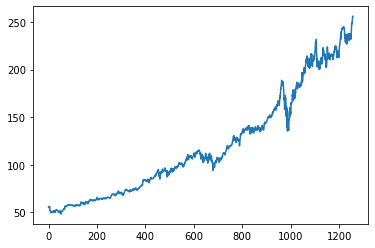

In [20]:
# Plotting the close price
plt.plot(df1)

Please note that LSTMs are sensitive to the scale of the data, so we will apply MinMax scaler technique to standardize the data.

In [23]:
# Using minmaxscaler to scale close price values
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [24]:
print(df1)

[[0.03340081]
 [0.03479853]
 [0.03870253]
 ...
 [0.98717949]
 [0.99971082]
 [1.        ]]


In [25]:
# Splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [26]:
training_size,test_size

(817, 440)

In [27]:
train_data[:5]

array([[0.03340081],
       [0.03479853],
       [0.03870253],
       [0.03836514],
       [0.03450935]])

Given below is one of the most important step in this forecasting process where we create X and Y data from the given data based on the timestamp. 

In [28]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   # For example i=0 will have 0,1,2,3-----99 -> x & 100 -> y
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    
    return np.array(dataX), np.array(dataY)

In [39]:
time_step = 100 # reshape into X=t,t+1,t+2,t+3....t+99 and Y=t+100

X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [40]:
print(X_train.shape), print(y_train.shape)

(716, 100)
(716,)


(None, None)

In [41]:
print(X_test.shape), print(ytest.shape)

(339, 100)
(339,)


(None, None)

In [43]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [45]:
print(X_train.shape), print(X_test.shape)

(716, 100, 1)
(339, 100, 1)


(None, None)

In [47]:
# Create the Stacked LSTM model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [48]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [51]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 5s 192ms/step - loss: 0.0306 - val_loss: 0.0875
Epoch 2/100
12/12 [==============================] - 1s 87ms/step - loss: 0.0036 - val_loss: 0.0083
Epoch 3/100
12/12 [==============================] - 1s 89ms/step - loss: 0.0011 - val_loss: 0.0038
Epoch 4/100
12/12 [==============================] - 1s 91ms/step - loss: 3.0378e-04 - val_loss: 0.0028
Epoch 5/100
12/12 [==============================] - 1s 92ms/step - loss: 2.2248e-04 - val_loss: 0.0026
Epoch 6/100
12/12 [==============================] - 1s 94ms/step - loss: 1.8508e-04 - val_loss: 0.0021
Epoch 7/100
12/12 [==============================] - 1s 93ms/step - loss: 1.7894e-04 - val_loss: 0.0021
Epoch 8/100
12/12 [==============================] - 1s 96ms/step - loss: 1.7246e-04 - val_loss: 0.0021
Epoch 9/100
12/12 [==============================] - 1s 96ms/step - loss: 2.0147e-04 - val_loss: 0.0021
Epoch 10/100
12/12 [==============================] - 1s 99ms/step - loss: 

12/12 [==============================] - 2s 133ms/step - loss: 1.3263e-04 - val_loss: 0.0012
Epoch 79/100
12/12 [==============================] - 2s 131ms/step - loss: 1.3985e-04 - val_loss: 0.0014
Epoch 80/100
12/12 [==============================] - 2s 130ms/step - loss: 1.1915e-04 - val_loss: 0.0012
Epoch 81/100
12/12 [==============================] - 2s 129ms/step - loss: 1.1028e-04 - val_loss: 0.0013
Epoch 82/100
12/12 [==============================] - 2s 131ms/step - loss: 1.1617e-04 - val_loss: 0.0013
Epoch 83/100
12/12 [==============================] - 2s 133ms/step - loss: 1.3726e-04 - val_loss: 0.0012
Epoch 84/100
12/12 [==============================] - 2s 129ms/step - loss: 1.2726e-04 - val_loss: 0.0012
Epoch 85/100
12/12 [==============================] - 2s 130ms/step - loss: 1.2602e-04 - val_loss: 0.0015
Epoch 86/100
12/12 [==============================] - 2s 129ms/step - loss: 1.4418e-04 - val_loss: 0.0011
Epoch 87/100
12/12 [==============================] - 2s 13

In [52]:
# Performing predictions and evluating performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [53]:
# Transform back to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [56]:
# Calculate RMSE performance metric
math.sqrt(mean_squared_error(y_train,train_predict))

91.43987305749637

In [57]:
# Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

197.12575762989218

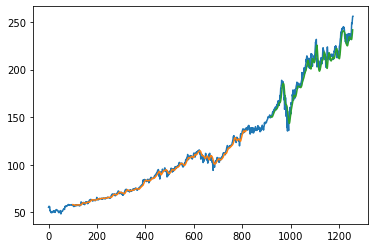

In [59]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [60]:
len(test_data)

440

In [66]:
x_input=test_data[340:].reshape(1,-1)
x_input.shape

(1, 100)

In [67]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [68]:
temp_input[:5]

[0.813572392519761,
 0.800221708116445,
 0.7839309812994025,
 0.7903894351262771,
 0.7806053595527279]

In [81]:
# Forecasting prediction for next 10 days

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

0 day input [0.90037594 0.88403702 0.9029304  0.9346443  0.96703297 0.96120108
 0.97103335 0.98717949 0.99971082 1.         0.96378672 0.97446817
 0.97989774 0.98102498 0.97901523 0.97485524 0.96924561 0.96263385
 0.95529354 0.9473986  0.93907851 0.93044823 0.92162198 0.91271627
 0.90384728 0.89512646 0.88665581 0.87852585 0.8708117  0.8635723
 0.85685122 0.85067517 0.84505653 0.83999306 0.8354708  0.83146501
 0.82794219 0.8248623  0.82217932 0.81984437 0.81780642 0.81601483
 0.81441891 0.81297076 0.81162441 0.81033874 0.80907577 0.80780321
 0.80649233 0.80512065 0.80366957 0.80212611 0.80048192 0.79873186
 0.79687583 0.79491681 0.79286069 0.79071599 0.7884931  0.78620392
 0.7838617  0.78148007 0.77907258 0.77665269 0.77423358 0.77182728
 0.7694447  0.76709563 0.76478851 0.76253074 0.76032698 0.75818187
 0.75609773 0.75407606 0.7521168  0.75021917 0.7483812  0.74659979
 0.74487215 0.74319422 0.74156201 0.73997098 0.73841685 0.73689526
 0.73540199 0.73393315 0.73248506 0.73105425 0.7296

10 day output [[0.7005054]]
11 day input [0.97446817 0.97989774 0.98102498 0.97901523 0.97485524 0.96924561
 0.96263385 0.95529354 0.9473986  0.93907851 0.93044823 0.92162198
 0.91271627 0.90384728 0.89512646 0.88665581 0.87852585 0.8708117
 0.8635723  0.85685122 0.85067517 0.84505653 0.83999306 0.8354708
 0.83146501 0.82794219 0.8248623  0.82217932 0.81984437 0.81780642
 0.81601483 0.81441891 0.81297076 0.81162441 0.81033874 0.80907577
 0.80780321 0.80649233 0.80512065 0.80366957 0.80212611 0.80048192
 0.79873186 0.79687583 0.79491681 0.79286069 0.79071599 0.7884931
 0.78620392 0.7838617  0.78148007 0.77907258 0.77665269 0.77423358
 0.77182728 0.7694447  0.76709563 0.76478851 0.76253074 0.76032698
 0.75818187 0.75609773 0.75407606 0.7521168  0.75021917 0.7483812
 0.74659979 0.74487215 0.74319422 0.74156201 0.73997098 0.73841685
 0.73689526 0.73540199 0.73393315 0.73248506 0.73105425 0.7296381
 0.72823405 0.7268396  0.7254535  0.72407454 0.72270113 0.72133374
 0.71997118 0.71861386 0.7

21 day output [[0.6880239]]
22 day input [0.92162198 0.91271627 0.90384728 0.89512646 0.88665581 0.87852585
 0.8708117  0.8635723  0.85685122 0.85067517 0.84505653 0.83999306
 0.8354708  0.83146501 0.82794219 0.8248623  0.82217932 0.81984437
 0.81780642 0.81601483 0.81441891 0.81297076 0.81162441 0.81033874
 0.80907577 0.80780321 0.80649233 0.80512065 0.80366957 0.80212611
 0.80048192 0.79873186 0.79687583 0.79491681 0.79286069 0.79071599
 0.7884931  0.78620392 0.7838617  0.78148007 0.77907258 0.77665269
 0.77423358 0.77182728 0.7694447  0.76709563 0.76478851 0.76253074
 0.76032698 0.75818187 0.75609773 0.75407606 0.7521168  0.75021917
 0.7483812  0.74659979 0.74487215 0.74319422 0.74156201 0.73997098
 0.73841685 0.73689526 0.73540199 0.73393315 0.73248506 0.73105425
 0.7296381  0.72823405 0.7268396  0.7254535  0.72407454 0.72270113
 0.72133374 0.71997118 0.71861386 0.71726263 0.71591693 0.71457803
 0.71324658 0.71192306 0.71060878 0.70930403 0.70801008 0.70672739
 0.70545667 0.7041987

In [72]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [73]:
len(df1)

1257

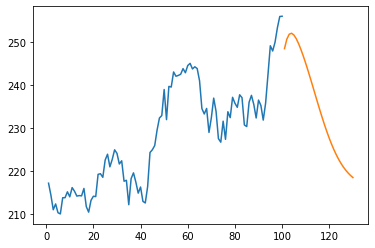

In [75]:
plt.plot(day_new,scaler.inverse_transform(df1[1157:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

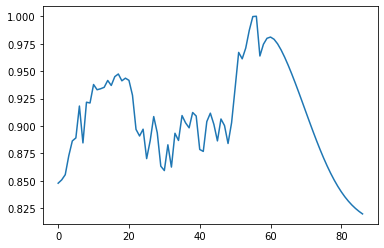

In [76]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [77]:
df3=scaler.inverse_transform(df3).tolist()

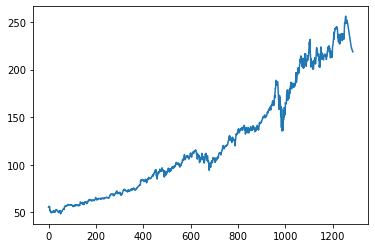

In [78]:
plt.plot(df3)